# Working with Geopandas

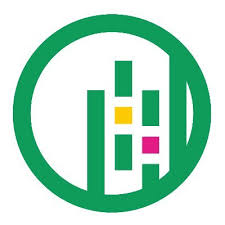

GeoPandas extends the Pandas library to enable spatial operations. It provides new data types such as **GeoDataFrame** and **GeoSeries** which are subclasses of Pandas **DataFrame** and **Series** and enables efficient vector data processing in Python.


GeoPandas make use of many other widely used spatial libraries - but it provides an interface similar to Pandas that make it intuitive to use it with spatial analysis. GeoPandas is built on top of the following libraries that allow it to be spatially aware.

- [Shapely](https://shapely.readthedocs.io/en/latest/manual.html) for geometric operations (i.e. buffer, intersections etc.)
- [PyProj](https://pyproj4.github.io/pyproj/stable/index.html) for working with projections
- [Fiona](https://pypi.org/project/Fiona/) for file input and output, which itself is based on the widely used [GDAL/OGR](https://gdal.org/) library

We will carry out a geoprocessing task that shows various features of this library and show how to do geo data processing in Python. The task is to take a roads data layer from OpenStreetMap and compute the total length of National Highways for each district in a state. The problem is described in detail in my [Advanced QGIS](https://courses.spatialthoughts.com/advanced-qgis.html#exercise-find-the-length-of-national-highways-in-a-state) course and show the steps needed to perform this analysis in QGIS. We will replicate this example in Python.

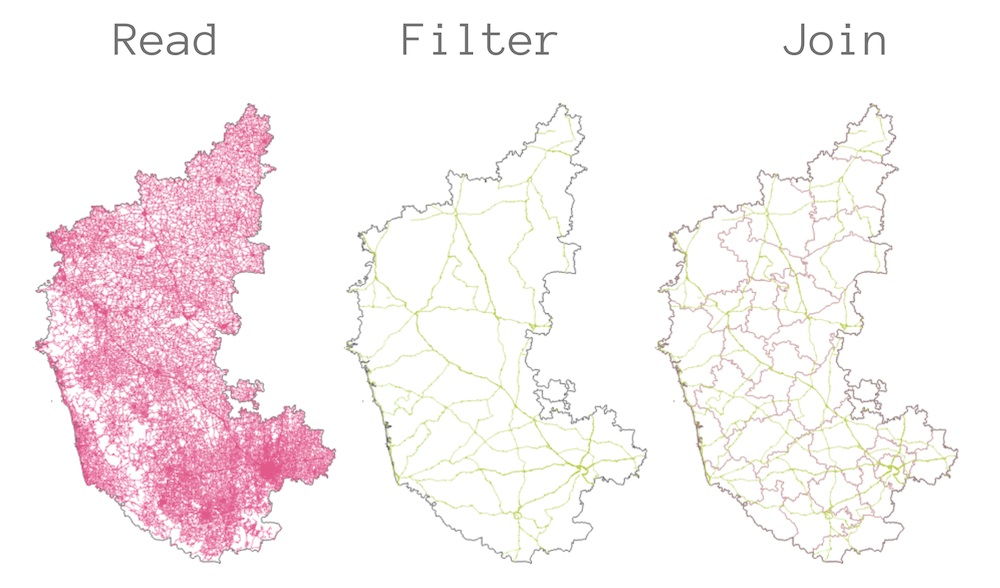


By convention, `geopandas` is commonly imported as `gpd`

In [1]:
import geopandas as gpd

## Reading Spatial Data

In [2]:
import os
data_pkg_path = 'data'
filename = 'karnataka.gpkg'
path = os.path.join(data_pkg_path, filename)

GeoPandas has a `read_file()` method that is able to open a wide variety of vector datasets, including zip files. Here we will open the GeoPackage `karnataka.gpkg` and read a layer called `karnataka_major_roads`. The result of the read method is a **GeoDataFrame**. 

In [3]:
roads_gdf = gpd.read_file(path, layer='karnataka_major_roads')
roads_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 44606 entries, 0 to 44605
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   osm_id    44606 non-null  object  
 1   code      44606 non-null  int64   
 2   fclass    44606 non-null  object  
 3   name      7018 non-null   object  
 4   ref       7702 non-null   object  
 5   oneway    44606 non-null  object  
 6   maxspeed  44606 non-null  int64   
 7   layer     44606 non-null  int64   
 8   bridge    44606 non-null  object  
 9   tunnel    44606 non-null  object  
 10  geometry  44606 non-null  geometry
dtypes: geometry(1), int64(3), object(7)
memory usage: 3.7+ MB


A GeoDataFrame contains a special column called *geometry*. All spatial operations on the GeoDataFrame are applied to the geomety column. The geometry column can be accessed using the `geometry` attribute.

In [4]:
roads_gdf.geometry

0        MULTILINESTRING ((77.59928 12.97672, 77.59950 ...
1        MULTILINESTRING ((76.65944 12.31809, 76.65904 ...
2        MULTILINESTRING ((76.65906 12.31389, 76.65912 ...
3        MULTILINESTRING ((76.65600 12.30895, 76.65646 ...
4        MULTILINESTRING ((76.65615 12.30989, 76.65600 ...
                               ...                        
44601    MULTILINESTRING ((77.60806 12.97517, 77.60797 ...
44602    MULTILINESTRING ((77.60798 12.97519, 77.60806 ...
44603    MULTILINESTRING ((77.57115 13.00849, 77.57156 ...
44604    MULTILINESTRING ((77.70140 12.95693, 77.70164 ...
44605    MULTILINESTRING ((77.61040 12.97360, 77.61052 ...
Name: geometry, Length: 44606, dtype: geometry

## Filtering Data

We can use the standard pandas filtering methods to select a subset of the GeoDataFrame. In addition, GeoPandas also provides a way to subset the data based on a `bounding box` with the [`cx[]` indexer](https://geopandas.readthedocs.io/en/latest/indexing.html).

For our analysis, we need to apply a filter to extract only the road segments where the `ref` attribute starts with **'NH'** - indicating a national highway. We can apply boolean filtering using Panda's `str.match()` method with a regular expression.

### National Highways

In [5]:
# filter to include only national highways
national = roads_gdf[roads_gdf['ref'].str.match('^NH') == True]
national.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
17,8684837,5112,trunk,Bengaluru - Mangaluru Road,NH373,F,0,0,F,F,"MULTILINESTRING ((76.10024 13.00326, 76.09950 ..."
26,9951034,5112,trunk,None,NH948,B,50,0,F,F,"MULTILINESTRING ((77.16472 12.24774, 77.16416 ..."
54,22838314,5112,trunk,Solapur-Mangalore Highway,NH169,B,0,0,F,F,"MULTILINESTRING ((74.86387 12.88387, 74.86419 ..."
55,22838318,5112,trunk,None,NH66,B,0,0,F,F,"MULTILINESTRING ((74.78756 13.09142, 74.78744 ..."
56,22838318,5112,trunk,None,NH66,B,0,0,F,F,"MULTILINESTRING ((74.78767 13.09723, 74.78767 ..."


## Working with Projections

Dealing with projetions is a key aspect of working with spatial data. GeoPandas uses the `pyproj` library to assign and manage projections. Each GeoDataFrame as a `crs` attribute that contains the projection info. Our source dataset is in EPSG:4326 WGS84 CRS.

In [6]:
national.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Since our task is to compute line lengths, we need to use a Projected CRS. We can use the `to_crs()` method to reproject the GeoDataFrame.

In [7]:
national_reprojected = national.to_crs('EPSG:32643')
national_reprojected.crs

<Derived Projected CRS: EPSG:32643>
Name: WGS 84 / UTM zone 43N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°E and 78°E, northern hemisphere between equator and 84°N, onshore and offshore. China. India. Kazakhstan. Kyrgyzstan. Maldives. Pakistan. Russian Federation. Tajikistan.
- bounds: (72.0, 0.0, 78.0, 84.0)
Coordinate Operation:
- name: UTM zone 43N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now that the layer has been reprojected, we can calculate the length of each geometry using the `length` attribute. The result would be in meters. We can add the line lengths in a new column named `length`.

In [8]:
# add a new column length with values calculated using .length
national_reprojected['length'] = national_reprojected['geometry'].length
national_reprojected

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,length
17,8684837,5112,trunk,Bengaluru - Mangaluru Road,NH373,F,0,0,F,F,"MULTILINESTRING ((619317.005 1437753.696, 6192...",2352.939132
26,9951034,5112,trunk,None,NH948,B,50,0,F,F,"MULTILINESTRING ((735483.761 1354892.067, 7354...",12876.925507
54,22838314,5112,trunk,Solapur-Mangalore Highway,NH169,B,0,0,F,F,"MULTILINESTRING ((485231.162 1424297.721, 4852...",822.021433
55,22838318,5112,trunk,None,NH66,B,0,0,F,F,"MULTILINESTRING ((476971.413 1447255.675, 4769...",648.925208
56,22838318,5112,trunk,None,NH66,B,0,0,F,F,"MULTILINESTRING ((476983.371 1447897.309, 4769...",2.174429
...,...,...,...,...,...,...,...,...,...,...,...,...
44466,760685447,5112,trunk,Outer Ring Road,NH75,F,60,0,F,F,"MULTILINESTRING ((779647.578 1443830.443, 7796...",58.845924
44531,762411542,5112,trunk,None,NH67,B,0,0,F,F,"MULTILINESTRING ((655805.451 1685461.453, 6557...",1369.334392
44550,762500475,5112,trunk,Bangalore-Mysore Road,NH275,F,60,0,F,F,"MULTILINESTRING ((773250.891 1431440.090, 7732...",487.316586
44551,762500476,5112,trunk,Mysore Road,NH275,F,0,0,F,F,"MULTILINESTRING ((774830.213 1432681.650, 7748...",15.561979


In [9]:
national_reprojected.describe()

,code,maxspeed,layer,length
count,3311.000000,3311.000000,3311.000000,3311.000000
mean,5112.108426,18.215041,0.252190,2602.285128
std,1.612646,31.249657,0.465882,4866.887481
min,5111.000000,0.000000,-1.000000,0.000025
25%,5112.000000,0.000000,0.000000,88.911240
50%,5112.000000,0.000000,0.000000,498.128633
75%,5112.000000,50.000000,1.000000,2595.681483
max,5134.000000,100.000000,2.000000,41790.161822


We have 3,311 national highways, with an average length of 2.6km. Note the longest road is just under 42km.

We can apply statistical operations on a DataFrame columns. Here we can compute the total length of national highways in the state by calling the `sum()` method.

In [11]:
total_length_national = national_reprojected['length'].sum()
print('Total length of national highways in the state is {} km'.format(total_length_national/1000)) # note that when there is a calc involved need to have this OUTSIDE the {} of the string

Total length of national highways in the state is 8616.166058402965 km


### State Highways

In [12]:
# filter to include only national highways
state = roads_gdf[roads_gdf['ref'].str.match('^SH') == True]
state.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
15,8682923,5113,primary,None,SH57,B,0,0,F,F,"MULTILINESTRING ((75.85801 13.22145, 75.85770 ..."
16,8682923,5113,primary,None,SH57,B,0,0,F,F,"MULTILINESTRING ((75.85072 13.25537, 75.84943 ..."
18,8684838,5113,primary,None,SH21,B,0,0,F,F,"MULTILINESTRING ((76.09352 12.99012, 76.09367 ..."
19,8684840,5113,primary,Bengaluru - Mangaluru Road,SH71E,F,0,0,F,F,"MULTILINESTRING ((76.06072 12.99247, 76.06179 ..."
32,22837475,5113,primary,None,SH94,B,0,0,F,F,"MULTILINESTRING ((77.22013 12.55935, 77.22019 ..."


In [13]:
state_reprojected = state.to_crs('EPSG:32643')
state_reprojected.crs

<Derived Projected CRS: EPSG:32643>
Name: WGS 84 / UTM zone 43N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°E and 78°E, northern hemisphere between equator and 84°N, onshore and offshore. China. India. Kazakhstan. Kyrgyzstan. Maldives. Pakistan. Russian Federation. Tajikistan.
- bounds: (72.0, 0.0, 78.0, 84.0)
Coordinate Operation:
- name: UTM zone 43N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
# add a new column length with values calculated using .length
state_reprojected['length'] = state_reprojected['geometry'].length
state_reprojected

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,length
15,8682923,5113,primary,None,SH57,B,0,0,F,F,"MULTILINESTRING ((592964.054 1461784.277, 5929...",4144.215242
16,8682923,5113,primary,None,SH57,B,0,0,F,F,"MULTILINESTRING ((592160.906 1465533.695, 5920...",8038.346479
18,8684838,5113,primary,None,SH21,B,0,0,F,F,"MULTILINESTRING ((618594.023 1436297.931, 6186...",210.312069
19,8684840,5113,primary,Bengaluru - Mangaluru Road,SH71E,F,0,0,F,F,"MULTILINESTRING ((615035.084 1436542.923, 6151...",120.006568
32,22837475,5113,primary,None,SH94,B,0,0,F,F,"MULTILINESTRING ((741226.855 1389423.900, 7412...",10524.883167
...,...,...,...,...,...,...,...,...,...,...,...,...
44514,761444468,5113,primary,None,SH35,B,0,0,F,F,"MULTILINESTRING ((799523.209 1440280.062, 7995...",653.837773
44515,761444469,5113,primary,None,SH35,B,0,0,F,F,"MULTILINESTRING ((799527.170 1440290.202, 7995...",10.886441
44516,761448593,5113,primary,None,SH35,B,0,0,F,F,"MULTILINESTRING ((799604.081 1440599.481, 7996...",319.761861
44517,761448599,5113,primary,None,SH35,B,0,0,F,F,"MULTILINESTRING ((799560.685 1441405.009, 7995...",810.066272


In [15]:
state_reprojected.describe()

,code,maxspeed,layer,length
count,4089.000000,4089.000000,4089.000000,4089.000000
mean,5113.152605,1.897775,0.135975,4534.348215
std,1.698737,9.946939,0.364253,5836.549623
min,5112.000000,0.000000,-1.000000,0.000046
25%,5113.000000,0.000000,0.000000,234.599808
50%,5113.000000,0.000000,0.000000,2053.940696
75%,5113.000000,0.000000,0.000000,6943.546952
max,5133.000000,80.000000,2.000000,55420.179020


We have 4,089 state highways, with an average length of just over 4.5km. Note the longest road is 55.4km.

In [17]:
total_length_state = state_reprojected['length'].sum()
print('Total length of state highways in the state is {} km'.format(total_length_state/1000)) # note that when there is a calc involved need to have this OUTSIDE the {} of the string

Total length of state highways in the state is 18540.949851239286 km


## Performing Spatial joins

There are two ways to combine datasets in geopandas – table joins and spatial joins. For our task, we need information about which district each road segments belongs to. This can be achived using another spatial layer for the districts and doing a spatial join to transfer the attributes of the district layer to the matching road segment.

The `karnataka.gpkg` contains a layer called `karnataka_districts` with the district boundaries and names.

In [18]:
districts_gdf = gpd.read_file(path, layer='karnataka_districts')
districts_gdf

,DISTRICT,ST_NM,ST_CEN_CD,DT_CEN_CD,censuscode,geometry
0,Bagalkot,Karnataka,29,2,556,"MULTIPOLYGON (((76.24100 16.16531, 76.23538 16..."
1,Bangalore Rural,Karnataka,29,29,583,"MULTIPOLYGON (((77.38701 13.50002, 77.40099 13..."
2,Bangalore,Karnataka,29,18,572,"MULTIPOLYGON (((77.83549 12.86809, 77.83213 12..."
3,Belgaum,Karnataka,29,1,555,"MULTIPOLYGON (((75.02647 16.93264, 75.02827 16..."
4,Bellary,Karnataka,29,11,565,"MULTIPOLYGON (((77.15757 15.13706, 77.15887 15..."
5,Bidar,Karnataka,29,4,558,"MULTIPOLYGON (((77.34032 18.43689, 77.34510 18..."
6,Bijapur,Karnataka,29,3,557,"MULTIPOLYGON (((76.07344 17.33403, 76.07030 17..."
7,Chamrajnagar,Karnataka,29,24,578,"MULTIPOLYGON (((77.32282 12.30709, 77.32726 12..."
8,Chikkaballapura,Karnataka,29,28,582,"MULTIPOLYGON (((78.19960 13.56615, 78.19897 13..."
9,Chikmagalur,Karnataka,29,16,570,"MULTIPOLYGON (((76.35411 13.57770, 76.35611 13..."


We have 30 districts.

Before joining this layer to the roads, we must reproject it to match the CRS of the roads layer.

In [19]:
districts_reprojected = districts_gdf.to_crs('EPSG:32643')
districts_reprojected.head()

,DISTRICT,ST_NM,ST_CEN_CD,DT_CEN_CD,censuscode,geometry
0,Bagalkot,Karnataka,29,2,556,"MULTIPOLYGON (((632675.845 1787621.162, 632097..."
1,Bangalore Rural,Karnataka,29,29,583,"MULTIPOLYGON (((758389.949 1493688.704, 759910..."
2,Bangalore,Karnataka,29,18,572,"MULTIPOLYGON (((807759.444 1424245.749, 807399..."
3,Belgaum,Karnataka,29,1,555,"MULTIPOLYGON (((502819.072 1872103.121, 503010..."
4,Bellary,Karnataka,29,11,565,"MULTIPOLYGON (((731854.580 1674625.393, 732005..."


Note how the coordinates in the `geometry` column have changed to reflect the reprojection of the CRS.

A spatial join is performed using the `sjoin()` method. It takes 2 core arguments.

- `predicate`: The spatial predicate to decdie which objects to join. Options are *intersects*, *within* and *contains*.
- `how`: The type of join to perform. Options are *left*, *right* and *inner*.

For our task, we can do a *left* join and add attributes of the district that *intersect* the road.


### National Highways including district intersection

In [20]:
joined_national = gpd.sjoin(national_reprojected, districts_reprojected, how='left', predicate='intersects')
joined_national

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,length,index_right,DISTRICT,ST_NM,ST_CEN_CD,DT_CEN_CD,censuscode
17,8684837,5112,trunk,Bengaluru - Mangaluru Road,NH373,F,0,0,F,F,"MULTILINESTRING ((619317.005 1437753.696, 6192...",2352.939132,16.0,Hassan,Karnataka,29.0,20.0,574.0
26,9951034,5112,trunk,None,NH948,B,50,0,F,F,"MULTILINESTRING ((735483.761 1354892.067, 7354...",12876.925507,7.0,Chamrajnagar,Karnataka,29.0,24.0,578.0
54,22838314,5112,trunk,Solapur-Mangalore Highway,NH169,B,0,0,F,F,"MULTILINESTRING ((485231.162 1424297.721, 4852...",822.021433,11.0,Dakshina Kannada,Karnataka,29.0,21.0,575.0
55,22838318,5112,trunk,None,NH66,B,0,0,F,F,"MULTILINESTRING ((476971.413 1447255.675, 4769...",648.925208,11.0,Dakshina Kannada,Karnataka,29.0,21.0,575.0
55,22838318,5112,trunk,None,NH66,B,0,0,F,F,"MULTILINESTRING ((476971.413 1447255.675, 4769...",648.925208,27.0,Udupi,Karnataka,29.0,15.0,569.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44466,760685447,5112,trunk,Outer Ring Road,NH75,F,60,0,F,F,"MULTILINESTRING ((779647.578 1443830.443, 7796...",58.845924,2.0,Bangalore,Karnataka,29.0,18.0,572.0
44531,762411542,5112,trunk,None,NH67,B,0,0,F,F,"MULTILINESTRING ((655805.451 1685461.453, 6557...",1369.334392,4.0,Bellary,Karnataka,29.0,11.0,565.0
44550,762500475,5112,trunk,Bangalore-Mysore Road,NH275,F,60,0,F,F,"MULTILINESTRING ((773250.891 1431440.090, 7732...",487.316586,2.0,Bangalore,Karnataka,29.0,18.0,572.0
44551,762500476,5112,trunk,Mysore Road,NH275,F,0,0,F,F,"MULTILINESTRING ((774830.213 1432681.650, 7748...",15.561979,2.0,Bangalore,Karnataka,29.0,18.0,572.0


Note that although we only have 3,311 national highways, we have 3,348 observations. This is explained by the fact that any particular highway may intersect with more than one district.

### State Highways including district intersection

In [21]:
joined_state = gpd.sjoin(state_reprojected, districts_reprojected, how='left', predicate='intersects')
joined_state

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,length,index_right,DISTRICT,ST_NM,ST_CEN_CD,DT_CEN_CD,censuscode
15,8682923,5113,primary,None,SH57,B,0,0,F,F,"MULTILINESTRING ((592964.054 1461784.277, 5929...",4144.215242,16.0,Hassan,Karnataka,29.0,20.0,574.0
16,8682923,5113,primary,None,SH57,B,0,0,F,F,"MULTILINESTRING ((592160.906 1465533.695, 5920...",8038.346479,16.0,Hassan,Karnataka,29.0,20.0,574.0
16,8682923,5113,primary,None,SH57,B,0,0,F,F,"MULTILINESTRING ((592160.906 1465533.695, 5920...",8038.346479,9.0,Chikmagalur,Karnataka,29.0,16.0,570.0
18,8684838,5113,primary,None,SH21,B,0,0,F,F,"MULTILINESTRING ((618594.023 1436297.931, 6186...",210.312069,16.0,Hassan,Karnataka,29.0,20.0,574.0
19,8684840,5113,primary,Bengaluru - Mangaluru Road,SH71E,F,0,0,F,F,"MULTILINESTRING ((615035.084 1436542.923, 6151...",120.006568,16.0,Hassan,Karnataka,29.0,20.0,574.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44514,761444468,5113,primary,None,SH35,B,0,0,F,F,"MULTILINESTRING ((799523.209 1440280.062, 7995...",653.837773,2.0,Bangalore,Karnataka,29.0,18.0,572.0
44515,761444469,5113,primary,None,SH35,B,0,0,F,F,"MULTILINESTRING ((799527.170 1440290.202, 7995...",10.886441,2.0,Bangalore,Karnataka,29.0,18.0,572.0
44516,761448593,5113,primary,None,SH35,B,0,0,F,F,"MULTILINESTRING ((799604.081 1440599.481, 7996...",319.761861,2.0,Bangalore,Karnataka,29.0,18.0,572.0
44517,761448599,5113,primary,None,SH35,B,0,0,F,F,"MULTILINESTRING ((799560.685 1441405.009, 7995...",810.066272,2.0,Bangalore,Karnataka,29.0,18.0,572.0


Note that although we only have 4,089 state highways, we have 4,326 observations. This is explained by the fact that any particular highway may intersect with more than one district.

We now have dataframes that includes roads, together with the district that that road runs through. There will be the case that a road runs through more than one district.

## Group Statistics

The resulting geodataframe now has the matching column from the intersecting district feature. We can now sum the length of the roads and group them by districts. This type of *Group Statistics* is performed using Panda's `group_by()` method.

In [22]:
national_results = joined_national.groupby('DISTRICT')['length'].sum()/1000
national_results

DISTRICT
Bagalkot            258.449475
Bangalore           314.170539
Bangalore Rural     319.965959
Belgaum             528.922541
Bellary             304.789522
Bidar               247.348300
Bijapur             424.197281
Chamrajnagar        217.737255
Chikkaballapura     209.154534
Chikmagalur         334.423573
Chitradurga         531.932443
Dakshina Kannada    316.339566
Davanagere          177.877407
Dharwad             314.978752
Gadag               111.548768
Gulbarga            294.551578
Hassan              436.231356
Haveri              306.582730
Kodagu               63.806864
Kolar               221.598406
Koppal              288.358711
Mandya              337.555904
Mysore              361.510005
Raichur             167.746669
Ramanagara          199.426362
Shimoga             479.140995
Tumkur              630.247609
Udupi               277.331577
Uttara Kannada      424.184040
Yadgir              144.858328
Name: length, dtype: float64

The result of the `group_by()` method is a Pandas *Series*. It can be saved to a CSV file using the `to_csv()` method.

In [23]:
output_filename = 'national_highways_by_districts.csv'
output_dir = 'output'
output_path = os.path.join(output_dir, output_filename)
national_results.to_csv(output_path)
print('Successfully written output file at {}'.format(output_path)) # have to include OUTside the {} and prefix with .format

Successfully written output file at output/national_highways_by_districts.csv


## Exercise

Before writing the output to the file, round the distance numbers to a whole number.

## My Solution

In [24]:
national_results = joined_national.groupby('DISTRICT')['length'].sum()/1000
national_results_rounded = national_results.round(0)
national_results_rounded

DISTRICT
Bagalkot            258.0
Bangalore           314.0
Bangalore Rural     320.0
Belgaum             529.0
Bellary             305.0
Bidar               247.0
Bijapur             424.0
Chamrajnagar        218.0
Chikkaballapura     209.0
Chikmagalur         334.0
Chitradurga         532.0
Dakshina Kannada    316.0
Davanagere          178.0
Dharwad             315.0
Gadag               112.0
Gulbarga            295.0
Hassan              436.0
Haveri              307.0
Kodagu               64.0
Kolar               222.0
Koppal              288.0
Mandya              338.0
Mysore              362.0
Raichur             168.0
Ramanagara          199.0
Shimoga             479.0
Tumkur              630.0
Udupi               277.0
Uttara Kannada      424.0
Yadgir              145.0
Name: length, dtype: float64

In [26]:
output_filename = 'national_highways_by_districts_rounded.csv'
output_dir = 'output'
output_path = os.path.join(output_dir, output_filename)
national_results_rounded.to_csv(output_path)
print('Successfully written output file at {}'.format(output_path))

Successfully written output file at output/national_highways_by_districts_rounded.csv
